![Quora-1.png](attachment:Quora-1.png)

#<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

#<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

#<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h2> 2.3 Train and Test Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

#<h1>3. Exploratory Data Analysis </h1>

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

In [46]:
#!pip install distance

In [47]:
#!pip install plotly

##<h2> 3.1 Reading data and basic stats </h2>

In [48]:
df = pd.read_csv("train.csv")

print("Number of data points:",df.shape[0])

Number of data points: 404290


In [49]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [50]:
df.info()#question 2 have 2 null value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

<h3> 3.2.1 Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

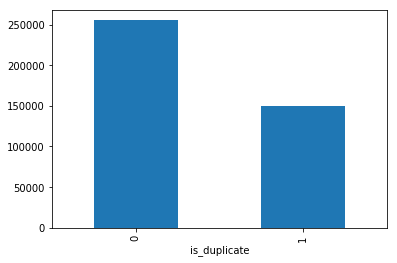

In [51]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [52]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   404290


In [53]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


In [54]:
df['is_duplicate'].value_counts(normalize=True)

0    0.630802
1    0.369198
Name: is_duplicate, dtype: float64

<h3> 3.2.2 Number of unique questions </h3>

In [55]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



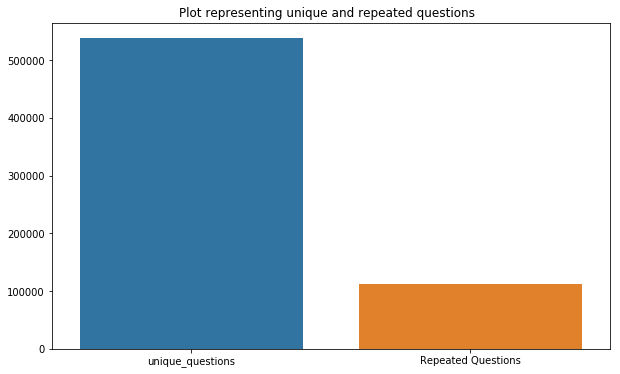

In [56]:

x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

<h3>3.2.3 Checking for Duplicates </h3>

In [57]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


<h3> 3.2.4 Number of occurrences of each question </h3>

Maximum number of times a single question is repeated: 157



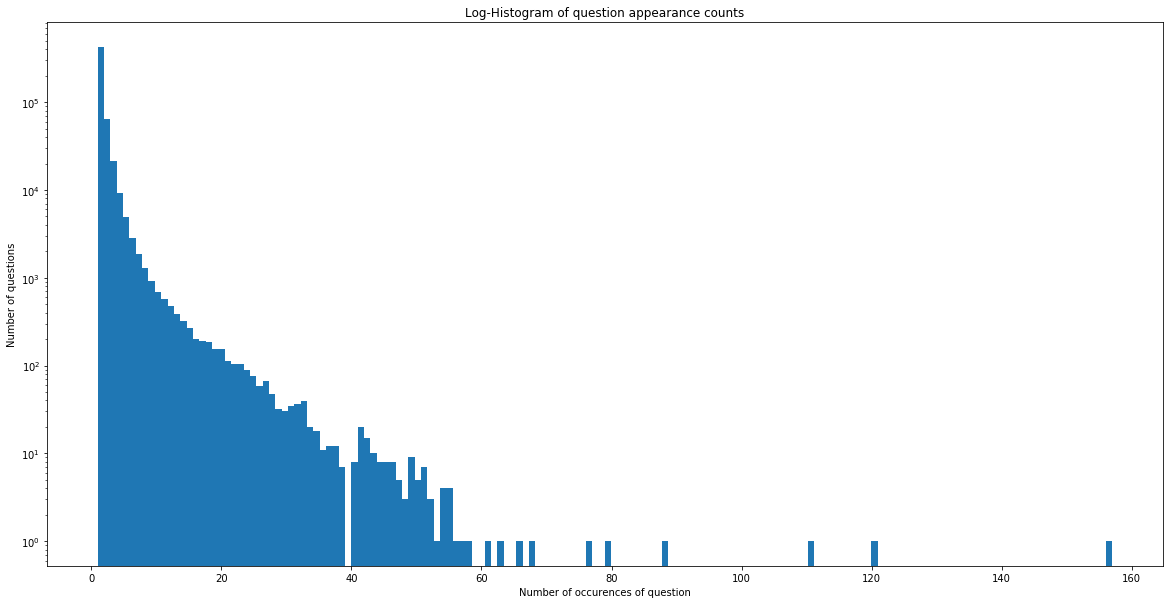

In [58]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

In [59]:
#number of question maximum are unique

<h3> 3.2.5 Checking for NULL values </h3>

In [60]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


- There are two rows with null values in question2 

In [61]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


##<h2>3.3 Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [62]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


<h3> 3.3.1 Analysis of some of the extracted features </h3>

- Here are some questions have only one single words.

In [63]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


<h4> 3.3.1.1 Feature: word_share </h4>

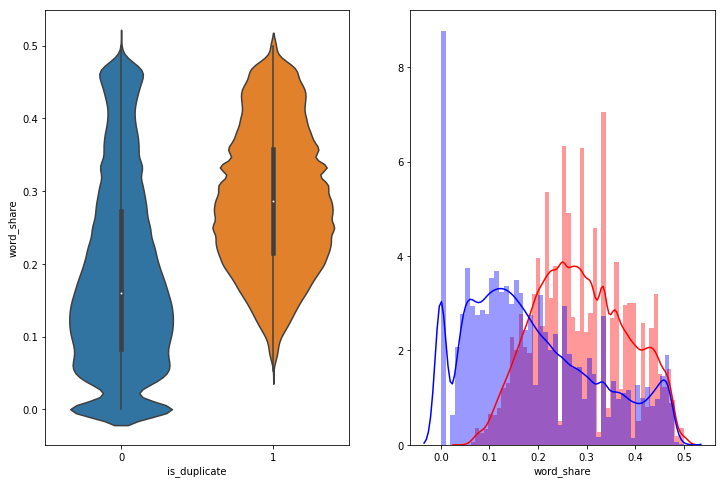

In [64]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

<h4> 3.3.1.2 Feature: word_Common </h4>

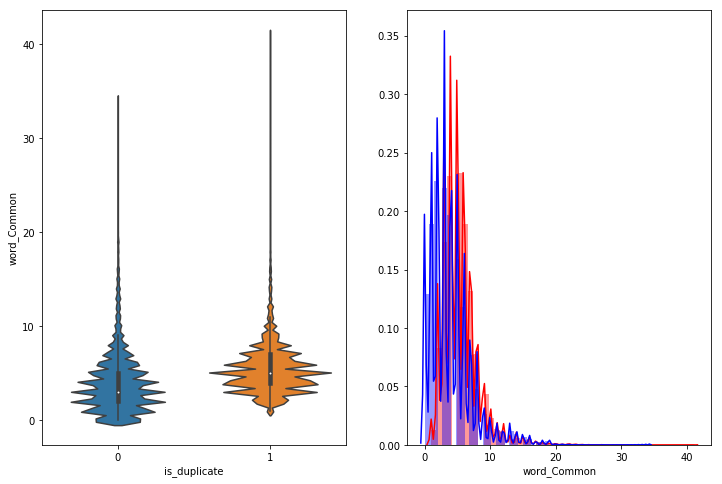

In [65]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

## 1.2.1 : EDA: Advanced Feature Extraction.


In [31]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc


import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image



In [67]:
#!pip install  wordcloud

In [68]:
#!pip install fuzzywuzzy

In [69]:
#https://stackoverflow.com/questions/12468179/unicodedecodeerror-utf8-codec-cant-decode-byte-0x9c
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
    df = df.fillna('')
    df.head()
else:
    print("get df_fe_without_preprocessing_train.csv from drive or run the previous notebook")

In [70]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


##<h2> 3.4 Preprocessing of Text </h2>

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [71]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 
import nltk
nltk.download('stopwords')
STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

[nltk_data] Downloading package stopwords to C:\Users\IDM
[nltk_data]     LAB-01\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


- Function to Compute and get the features : With 2 parameters of Question 1 and Question 2

<h2> 3.5 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [32]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [73]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


<h3>3.5.1 Analysis of extracted features </h3>

<h4> 3.5.1.1 Plotting Word clouds</h4>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [74]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s',encoding='utf-8')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [75]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16109886
Total number of words in non duplicate pair questions : 33194892


__ Word Clouds generated from  duplicate pair question's text __

Word Cloud for Duplicate Question pairs


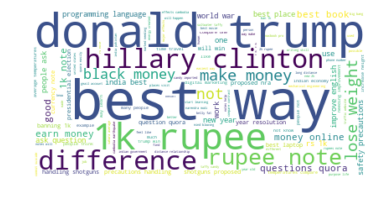

In [76]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

__ Word Clouds generated from non duplicate pair question's text __

Word Cloud for non-Duplicate Question pairs:


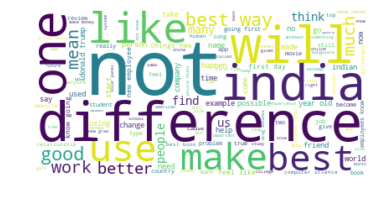

In [77]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [78]:
#some word occur more ooffen in class 1 than 0, and voiceversa

<h4> 3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] </h4>

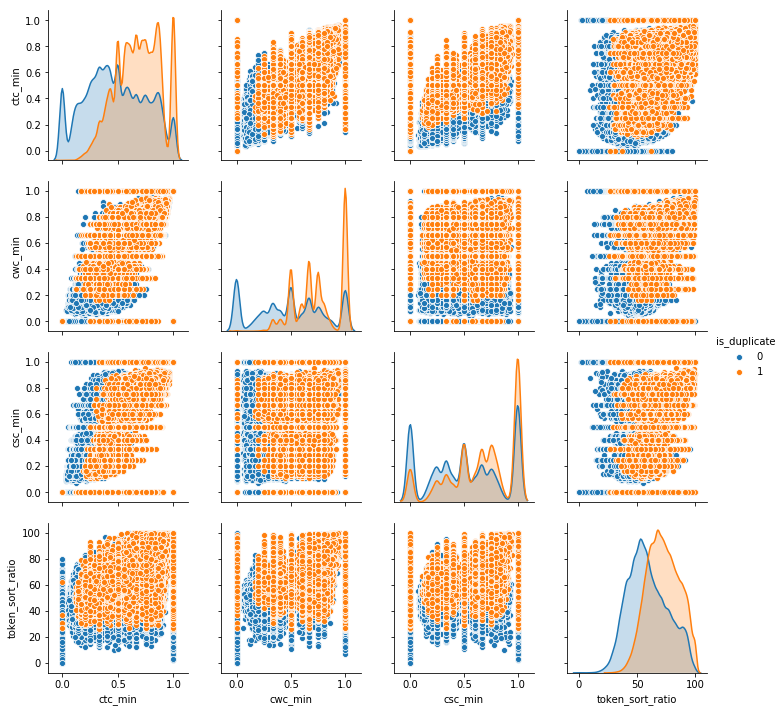

In [79]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

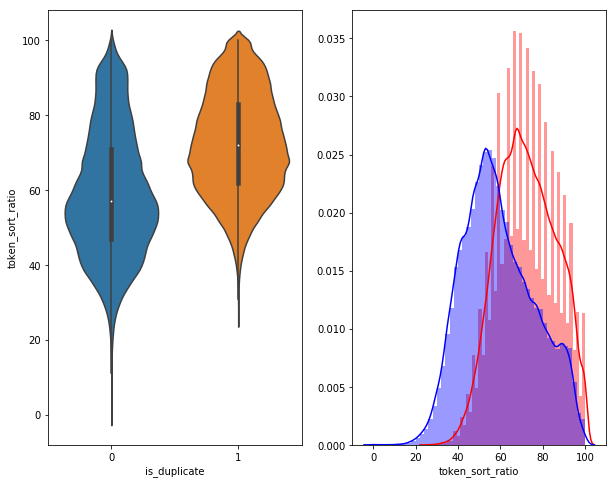

In [80]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

In [81]:
#token_sort_ratio is interesting feature because they dont fully  overlap.
#ideally they should fully seperated

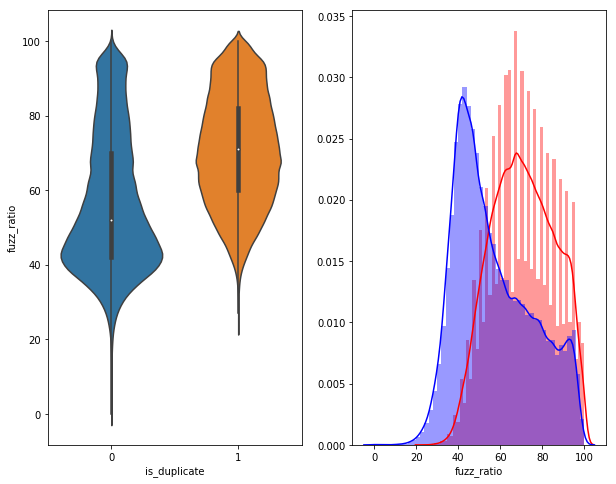

In [82]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

In [83]:
#fuzz_ratio useful to determining the classification problem

<h3>3.5.2 Visualization </h3>

In [84]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [85]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.016s...
[t-SNE] Computed neighbors for 5000 samples in 0.343s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.219s
[t-SNE] Iteration 50: error = 80.9162369, gradient norm = 0.0427600 (50 iterations in 2.458s)
[t-SNE] Iteration 100: error = 70.3915100, gradient norm = 0.0108003 (50 iterations in 1.803s)
[t-SNE] Iteration 150: error = 68.6126938, gradient norm = 0.0054721 (50 iterations in 1.799s)
[t-SNE] Iteration 200: error = 67.7680206, gradient norm = 0.0042246 (50 iterations in 1.872s)
[t-SNE] Iteration 250: error = 67.2733459, gradient norm = 0.0037275

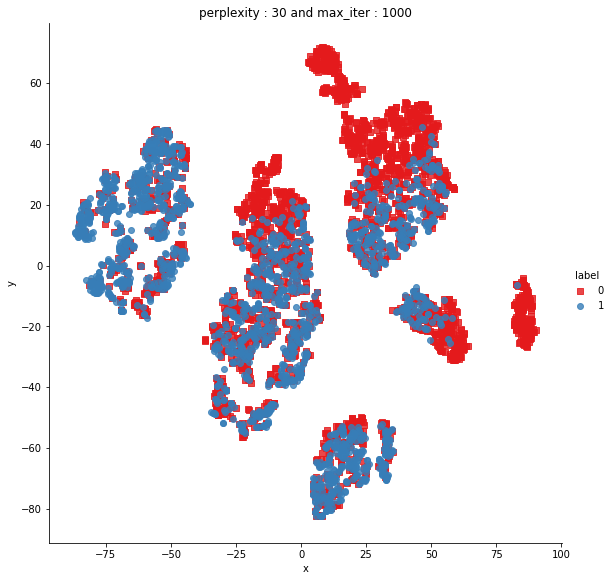

In [86]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [87]:
#
#15 dimentional data project in 2d. lot of class 0 point clearly seperable
#it means 15 feature design certainly useful in classification problem

In [88]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.009s...
[t-SNE] Computed neighbors for 5000 samples in 0.322s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.218s
[t-SNE] Iteration 50: error = 80.3552017, gradient norm = 0.0329941 (50 iterations in 8.997s)
[t-SNE] Iteration 100: error = 69.1100388, gradient norm = 0.0034323 (50 iterations in 5.261s)
[t-SNE] Iteration 150: error = 67.6163483, gradient norm = 0.0017810 (50 iterations in 4.758s)
[t-SNE] Iteration 200: error = 67.0578613, gradient norm = 0.0011246 (50 iterations in 4.614s)
[t-SNE] Iteration 250: error = 66.7297821, gradient norm = 0.0009272

In [89]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

##<h2> 3.6 Featurizing text data with tfidf weighted word-vectors </h2>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

In [ ]:
#!pip install spacy

In [2]:
# avoid decoding problems
df = pd.read_csv("train.csv")
 
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
df1 = dfnlp.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = dfnlp[['id','question1','question2']]
duplicate = dfnlp.is_duplicate

In [6]:
#df1=df1.drop('Unnamed: 0',axis=1)
df3 = df3.fillna(' ')
#assigning new dataframe with columns question(q1+q2) and id same as df3
new_df = pd.DataFrame()
new_df['questions'] = df3.question1 + ' ' + df3.question2
new_df['id'] = df3.id
df2['id']=df1['id']
new_df['id']=df1['id']
final_df = df1.merge(df2, on='id',how='left') #merging df1 and df2
X  = final_df.merge(new_df, on='id',how='left')#merging final_df and new_df

In [7]:
#removing id from X
X=X.drop('id',axis=1)
X.columns

Index(['cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common',
       'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2', 'questions'],
      dtype='object')

In [8]:
y=np.array(duplicate)

In [9]:
#splitting data into train and test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=3,test_size=0.3)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(283003, 27)
(283003,)
(121287, 27)
(121287,)


In [10]:
#seperating questions for tfidf vectorizer
X_train_ques=X_train['questions']
X_test_ques=X_test['questions']

X_train=X_train.drop('questions',axis=1)
X_test=X_test.drop('questions',axis=1)

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# list_of_sentance_train=[]
# for sentance in X_train_ques:
#     list_of_sentance_train.append(sentance.split())

tfidf = TfidfVectorizer(lowercase=False )
tfidf.fit_transform(X_train_ques)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [12]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
#for train dataset

nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_train_ques)):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), 96])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
#df['q1_feats_m'] = list(vecs1)


100%|████████████████████████████████████████████████████████████████████████| 283003/283003 [1:26:30<00:00, 54.52it/s]


In [13]:
vecs2 = []
for qu2 in tqdm(list(X_test_ques)):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), 96])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
#df['q2_feats_m'] = list(vecs2)

100%|██████████████████████████████████████████████████████████████████████████| 121287/121287 [33:32<00:00, 60.26it/s]


In [14]:
first_df=pd.DataFrame(vecs1)
sec_df=pd.DataFrame(vecs2)

In [15]:
from scipy.sparse import hstack
X_train = hstack((X_train.values,first_df))
X_test= hstack((X_test.values,sec_df))
print(X_train.shape)
print(X_test.shape)

(283003, 122)
(121287, 122)


In [16]:
# #prepro_features_train.csv (Simple Preprocessing Feartures)
# #nlp_features_train.csv (NLP Features)
# if os.path.isfile('nlp_features_train.csv'):
#     dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
# else:
#     print("download nlp_features_train.csv from drive or run previous notebook")

# if os.path.isfile('df_fe_without_preprocessing_train.csv'):
#     dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
# else:
#     print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [ ]:
# df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
# df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
# df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
# df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
# df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [ ]:
# dataframe of nlp features
# df1.head()

In [ ]:
# data before preprocessing 
# df2.head()

In [ ]:
# Questions 1 tfidf weighted word2vec
# df3_q1.head()

In [ ]:
# Questions 2 tfidf weighted word2vec
# df3_q2.head()

In [ ]:
# print("Number of features in nlp dataframe :", df1.shape[1])
# print("Number of features in preprocessed dataframe :", df2.shape[1])
# print("Number of features in question1 w2v  dataframe :", df3_q1.shape[1])
# print("Number of features in question2 w2v  dataframe :", df3_q2.shape[1])
# print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1])

In [ ]:
# # storing the final features to csv file
# if not os.path.isfile('final_features.csv'):
#     df3_q1['id']=df1['id']
#     df3_q2['id']=df1['id']
#     df1  = df1.merge(df2, on='id',how='left')
#     df2  = df3_q1.merge(df3_q2, on='id',how='left')
#     result  = df1.merge(df2, on='id',how='left')
#     result.to_csv('final_features.csv')

#<h1>4. Machine Learning Models </h1>

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [ ]:
#!pip install mlxtend 

<h1>4. Machine Learning Models </h1>

<h2> 4.1 Reading data from file and storing into sql table </h2>

In [116]:
# #Creating db file from csv
# if not os.path.isfile('train.db'):
#     disk_engine = create_engine('sqlite:///train.db')
#     start = dt.datetime.now()
#     chunksize = 180000
#     j = 0
#     index_start = 1
#     for df in pd.read_csv('final_features.csv', names=['Unnamed: 0','id','is_duplicate','cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio','freq_qid1','freq_qid2','q1len','q2len','q1_n_words','q2_n_words','word_Common','word_Total','word_share','freq_q1+q2','freq_q1-q2','0_x','1_x','2_x','3_x','4_x','5_x','6_x','7_x','8_x','9_x','10_x','11_x','12_x','13_x','14_x','15_x','16_x','17_x','18_x','19_x','20_x','21_x','22_x','23_x','24_x','25_x','26_x','27_x','28_x','29_x','30_x','31_x','32_x','33_x','34_x','35_x','36_x','37_x','38_x','39_x','40_x','41_x','42_x','43_x','44_x','45_x','46_x','47_x','48_x','49_x','50_x','51_x','52_x','53_x','54_x','55_x','56_x','57_x','58_x','59_x','60_x','61_x','62_x','63_x','64_x','65_x','66_x','67_x','68_x','69_x','70_x','71_x','72_x','73_x','74_x','75_x','76_x','77_x','78_x','79_x','80_x','81_x','82_x','83_x','84_x','85_x','86_x','87_x','88_x','89_x','90_x','91_x','92_x','93_x','94_x','95_x','96_x','97_x','98_x','99_x','100_x','101_x','102_x','103_x','104_x','105_x','106_x','107_x','108_x','109_x','110_x','111_x','112_x','113_x','114_x','115_x','116_x','117_x','118_x','119_x','120_x','121_x','122_x','123_x','124_x','125_x','126_x','127_x','128_x','129_x','130_x','131_x','132_x','133_x','134_x','135_x','136_x','137_x','138_x','139_x','140_x','141_x','142_x','143_x','144_x','145_x','146_x','147_x','148_x','149_x','150_x','151_x','152_x','153_x','154_x','155_x','156_x','157_x','158_x','159_x','160_x','161_x','162_x','163_x','164_x','165_x','166_x','167_x','168_x','169_x','170_x','171_x','172_x','173_x','174_x','175_x','176_x','177_x','178_x','179_x','180_x','181_x','182_x','183_x','184_x','185_x','186_x','187_x','188_x','189_x','190_x','191_x','192_x','193_x','194_x','195_x','196_x','197_x','198_x','199_x','200_x','201_x','202_x','203_x','204_x','205_x','206_x','207_x','208_x','209_x','210_x','211_x','212_x','213_x','214_x','215_x','216_x','217_x','218_x','219_x','220_x','221_x','222_x','223_x','224_x','225_x','226_x','227_x','228_x','229_x','230_x','231_x','232_x','233_x','234_x','235_x','236_x','237_x','238_x','239_x','240_x','241_x','242_x','243_x','244_x','245_x','246_x','247_x','248_x','249_x','250_x','251_x','252_x','253_x','254_x','255_x','256_x','257_x','258_x','259_x','260_x','261_x','262_x','263_x','264_x','265_x','266_x','267_x','268_x','269_x','270_x','271_x','272_x','273_x','274_x','275_x','276_x','277_x','278_x','279_x','280_x','281_x','282_x','283_x','284_x','285_x','286_x','287_x','288_x','289_x','290_x','291_x','292_x','293_x','294_x','295_x','296_x','297_x','298_x','299_x','300_x','301_x','302_x','303_x','304_x','305_x','306_x','307_x','308_x','309_x','310_x','311_x','312_x','313_x','314_x','315_x','316_x','317_x','318_x','319_x','320_x','321_x','322_x','323_x','324_x','325_x','326_x','327_x','328_x','329_x','330_x','331_x','332_x','333_x','334_x','335_x','336_x','337_x','338_x','339_x','340_x','341_x','342_x','343_x','344_x','345_x','346_x','347_x','348_x','349_x','350_x','351_x','352_x','353_x','354_x','355_x','356_x','357_x','358_x','359_x','360_x','361_x','362_x','363_x','364_x','365_x','366_x','367_x','368_x','369_x','370_x','371_x','372_x','373_x','374_x','375_x','376_x','377_x','378_x','379_x','380_x','381_x','382_x','383_x','0_y','1_y','2_y','3_y','4_y','5_y','6_y','7_y','8_y','9_y','10_y','11_y','12_y','13_y','14_y','15_y','16_y','17_y','18_y','19_y','20_y','21_y','22_y','23_y','24_y','25_y','26_y','27_y','28_y','29_y','30_y','31_y','32_y','33_y','34_y','35_y','36_y','37_y','38_y','39_y','40_y','41_y','42_y','43_y','44_y','45_y','46_y','47_y','48_y','49_y','50_y','51_y','52_y','53_y','54_y','55_y','56_y','57_y','58_y','59_y','60_y','61_y','62_y','63_y','64_y','65_y','66_y','67_y','68_y','69_y','70_y','71_y','72_y','73_y','74_y','75_y','76_y','77_y','78_y','79_y','80_y','81_y','82_y','83_y','84_y','85_y','86_y','87_y','88_y','89_y','90_y','91_y','92_y','93_y','94_y','95_y','96_y','97_y','98_y','99_y','100_y','101_y','102_y','103_y','104_y','105_y','106_y','107_y','108_y','109_y','110_y','111_y','112_y','113_y','114_y','115_y','116_y','117_y','118_y','119_y','120_y','121_y','122_y','123_y','124_y','125_y','126_y','127_y','128_y','129_y','130_y','131_y','132_y','133_y','134_y','135_y','136_y','137_y','138_y','139_y','140_y','141_y','142_y','143_y','144_y','145_y','146_y','147_y','148_y','149_y','150_y','151_y','152_y','153_y','154_y','155_y','156_y','157_y','158_y','159_y','160_y','161_y','162_y','163_y','164_y','165_y','166_y','167_y','168_y','169_y','170_y','171_y','172_y','173_y','174_y','175_y','176_y','177_y','178_y','179_y','180_y','181_y','182_y','183_y','184_y','185_y','186_y','187_y','188_y','189_y','190_y','191_y','192_y','193_y','194_y','195_y','196_y','197_y','198_y','199_y','200_y','201_y','202_y','203_y','204_y','205_y','206_y','207_y','208_y','209_y','210_y','211_y','212_y','213_y','214_y','215_y','216_y','217_y','218_y','219_y','220_y','221_y','222_y','223_y','224_y','225_y','226_y','227_y','228_y','229_y','230_y','231_y','232_y','233_y','234_y','235_y','236_y','237_y','238_y','239_y','240_y','241_y','242_y','243_y','244_y','245_y','246_y','247_y','248_y','249_y','250_y','251_y','252_y','253_y','254_y','255_y','256_y','257_y','258_y','259_y','260_y','261_y','262_y','263_y','264_y','265_y','266_y','267_y','268_y','269_y','270_y','271_y','272_y','273_y','274_y','275_y','276_y','277_y','278_y','279_y','280_y','281_y','282_y','283_y','284_y','285_y','286_y','287_y','288_y','289_y','290_y','291_y','292_y','293_y','294_y','295_y','296_y','297_y','298_y','299_y','300_y','301_y','302_y','303_y','304_y','305_y','306_y','307_y','308_y','309_y','310_y','311_y','312_y','313_y','314_y','315_y','316_y','317_y','318_y','319_y','320_y','321_y','322_y','323_y','324_y','325_y','326_y','327_y','328_y','329_y','330_y','331_y','332_y','333_y','334_y','335_y','336_y','337_y','338_y','339_y','340_y','341_y','342_y','343_y','344_y','345_y','346_y','347_y','348_y','349_y','350_y','351_y','352_y','353_y','354_y','355_y','356_y','357_y','358_y','359_y','360_y','361_y','362_y','363_y','364_y','365_y','366_y','367_y','368_y','369_y','370_y','371_y','372_y','373_y','374_y','375_y','376_y','377_y','378_y','379_y','380_y','381_y','382_y','383_y'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
#         df.index += index_start
#         j+=1
#         print('{} rows'.format(j*chunksize))
#         df.to_sql('data', disk_engine, if_exists='append')
#         index_start = df.index[-1] + 1

In [35]:
# #http://www.sqlitetutorial.net/sqlite-python/create-tables/
# def create_connection(db_file):
#     """ create a database connection to the SQLite database
#         specified by db_file
#     :param db_file: database file
#     :return: Connection object or None
#     """
#     try:
#         conn = sqlite3.connect(db_file)
#         return conn
#     except Error as e:
#         print(e)
 
#     return None


# def checkTableExists(dbcon):
#     cursr = dbcon.cursor()
#     str = "select name from sqlite_master where type='table'"
#     table_names = cursr.execute(str)
#     print("Tables in the databse:")
#     tables =table_names.fetchall() 
#     print(tables[0][0])
#     return(len(tables))

In [118]:
# read_db = 'train.db'
# conn_r = create_connection(read_db)
# checkTableExists(conn_r)
# conn_r.close()

Tables in the databse:
data


In [119]:
# # try to sample data according to the computing power you have
# if os.path.isfile(read_db):
#     conn_r = create_connection(read_db)
#     if conn_r is not None:
#         # for selecting first 1M rows
#         # data = pd.read_sql_query("""SELECT * FROM data LIMIT 100001;""", conn_r)
        
#         # for selecting random points
#         data = pd.read_sql_query("SELECT * From data ORDER BY RANDOM() LIMIT 100001;", conn_r)
#         conn_r.commit()
#         conn_r.close()

In [120]:
# # remove the first row 
# data.drop(data.index[0], inplace=True)
# y_true = data['is_duplicate']
# data.drop(['Unnamed: 0', 'id','index','is_duplicate'], axis=1, inplace=True)

In [121]:
# data.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
1,0.29999700003,0.214284183684402,0.333327777870369,0.181816528940646,0.277776234576475,0.172413198575177,0.0,0.0,11.0,23.5,...,29.3643498346209,37.999056249857,3.3456971347332,-7.77428346499801,31.3770857993513,0.690814405679703,-24.8942447900772,-2.7635256499052,21.9840773269534,5.57580267079175
2,0.749981250468738,0.749981250468738,0.999975000624984,0.666655555740738,0.874989062636717,0.699993000069999,0.0,1.0,2.0,9.0,...,7.89711719751358,8.01704338565469,-4.13183904439211,-1.68225284200162,1.36502695083618,11.5678869485855,-12.1020265221596,7.23875133693218,4.99518252909184,-0.180069230496883
3,0.749981250468738,0.749981250468738,0.799984000319994,0.666655555740738,0.77776913589849,0.699993000069999,0.0,1.0,1.0,9.5,...,3.82735014520586,3.12875586561859,7.54892219323665,-4.71988063585013,-4.14503436535597,2.53589966893196,-9.70349940657616,7.28034028410912,12.8604905456305,-2.88871638476849
4,0.499987500312492,0.499987500312492,0.999975000624984,0.499993750078124,0.749990625117186,0.499995833368055,0.0,1.0,4.0,10.0,...,6.64880137145519,8.92168019711971,13.9252632595599,-6.05639733653516,-0.776301544159651,6.56026335060596,-0.0606507752090693,4.03632082790136,-0.871298223733902,7.61504864692688
5,0.333327777870369,0.166665277789352,0.399992000159997,0.285710204139941,0.363633057881292,0.15999936000256,0.0,0.0,14.0,18.0,...,5.33633314818144,25.2298847287893,4.05405327677727,-4.71557768248022,32.8457696139813,-4.67221538722515,-38.376671589911,38.5577662717551,2.14505879953504,-2.49764843285084


<h2> 4.2 Converting strings to numerics </h2>

In [18]:
# # after we read from sql table each entry was read it as a string
# # we convert all the features into numaric before we apply any model
# cols = list(data.columns)
# for i in cols:
#     data[i] = data[i].apply(pd.to_numeric)
#     print(i)

In [19]:
# https://stackoverflow.com/questions/7368789/convert-all-strings-in-a-list-to-int
# y_true = list(map(int, y_true.values))

In [20]:
# 4.3 Random train test split( 70:30)

In [21]:
# X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

In [22]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (283003, 122)
Number of data points in test data : (121287, 122)


In [23]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6296541026066862 Class 1:  0.37034589739331386
---------- Distribution of output variable in train data ----------
Class 0:  0.3665190828365777 Class 1:  0.3665190828365777


In [24]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8875053502562997


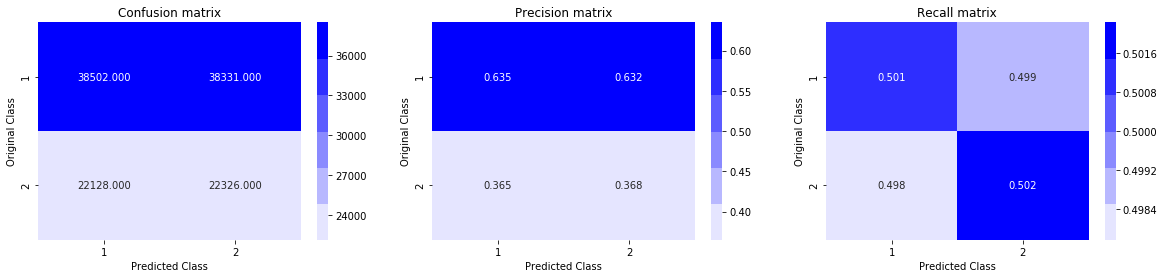

In [25]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.4647878313816819
For values of alpha =  0.0001 The log loss is: 0.4930443767576692
For values of alpha =  0.001 The log loss is: 0.46217996259395266
For values of alpha =  0.01 The log loss is: 0.45125839928843875
For values of alpha =  0.1 The log loss is: 0.4533765684058025
For values of alpha =  1 The log loss is: 0.4808821350734006
For values of alpha =  10 The log loss is: 0.5364235959274334


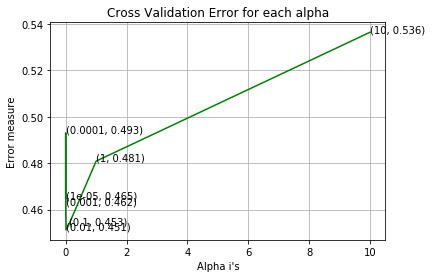

For values of best alpha =  0.01 The train log loss is: 0.4513364579230142
For values of best alpha =  0.01 The test log loss is: 0.45125839928843875
Total number of data points : 121287


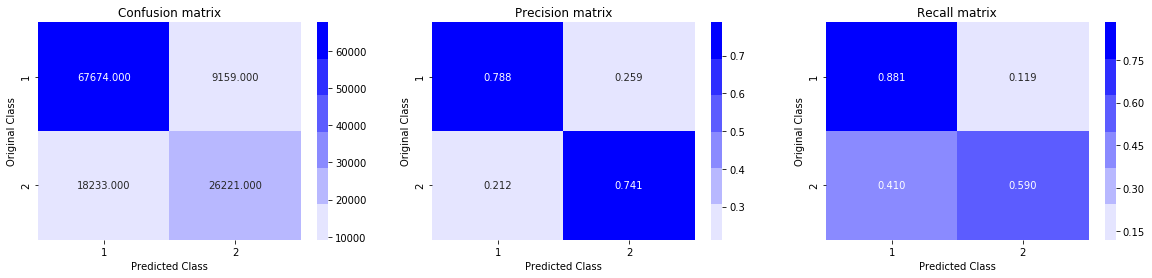

In [26]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

it is good to do feature scaling while using SGD classifier

In [61]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler(with_mean=False)
X_train_std = scale.fit_transform(X_train)
X_test_std = scale.transform(X_test)


alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train_std, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_std, y_train)
    predict_y = sig_clf.predict_proba(X_test_std)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train_std, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_std, y_train)

predict_y = sig_clf.predict_proba(X_train_std)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_std)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

it is seen that after standardizing the dataset, there is significant decrease in log_loss value

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.6593095387990768
For values of alpha =  0.0001 The log loss is: 0.4876647905346559
For values of alpha =  0.001 The log loss is: 0.5218329321706336
For values of alpha =  0.01 The log loss is: 0.5638142791135113
For values of alpha =  0.1 The log loss is: 0.5975063339304361
For values of alpha =  1 The log loss is: 0.6450030656330838
For values of alpha =  10 The log loss is: 0.6593095387990768


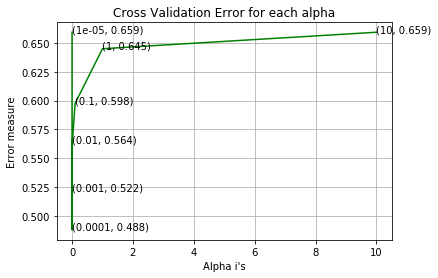

For values of best alpha =  0.0001 The train log loss is: 0.478578596724142
For values of best alpha =  0.0001 The test log loss is: 0.4876647905346559
Total number of data points : 30000


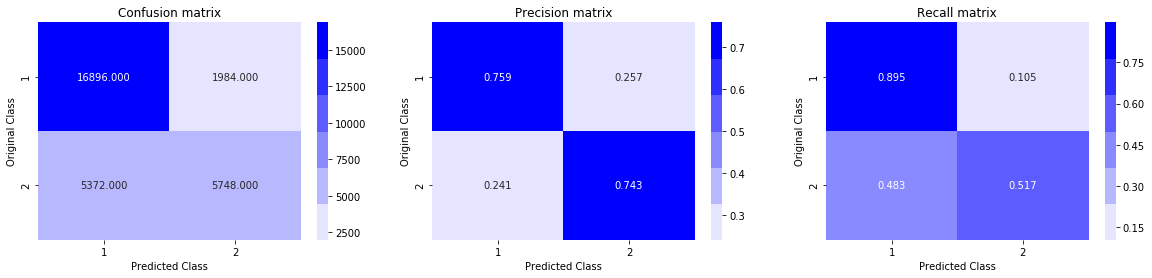

In [130]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

lets check after standardizing the dataset before applying SVM model

For values of alpha =  1e-05 The log loss is: 0.4417720967939409
For values of alpha =  0.0001 The log loss is: 0.4398034053426769
For values of alpha =  0.001 The log loss is: 0.4268263608040993
For values of alpha =  0.01 The log loss is: 0.4387025754756991
For values of alpha =  0.1 The log loss is: 0.5109130550412181
For values of alpha =  1 The log loss is: 0.6593095389881081
For values of alpha =  10 The log loss is: 0.659309538988108


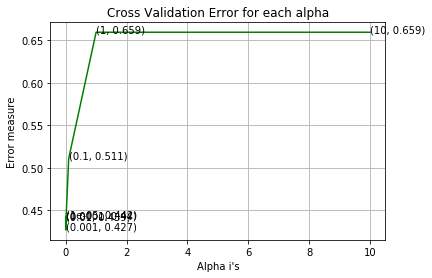

For values of best alpha =  0.001 The train log loss is: 0.4180234067450405
For values of best alpha =  0.001 The test log loss is: 0.4268263608040993
Total number of data points : 30000


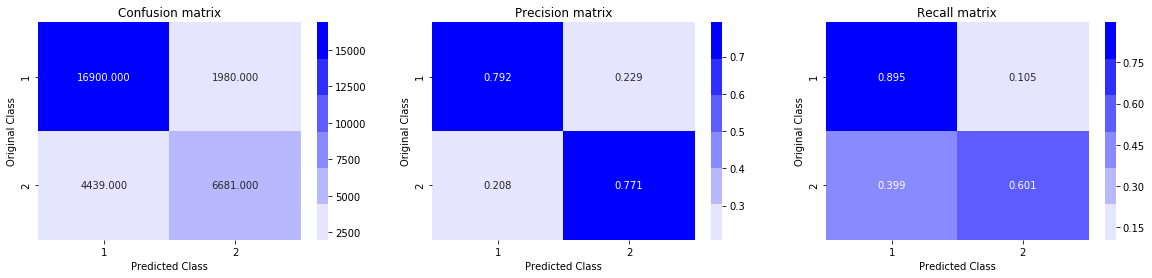

In [139]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
X_train_std_std = scale.fit_transform(X_train)
X_test_std_std = scale.transform(X_test)

alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train_std, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_std, y_train)
    predict_y = sig_clf.predict_proba(X_test_std)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train_std, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_std, y_train)

predict_y = sig_clf.predict_proba(X_train_std)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_std)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

after standardizing the dataset, error reduce significantly

<h2> 4.6 Random Forest </h2>

estimators =  100 \Train Log Loss  0.11931452467561336 \Test Log Loss  0.40072325988746726 \Loss difference between Test and Train 0.2814087352118539
estimators =  150 \Train Log Loss  0.11938972168207508 \Test Log Loss  0.399666879717787 \Loss difference between Test and Train 0.28027715803571196
estimators =  200 \Train Log Loss  0.11923935410379732 \Test Log Loss  0.3992913854555931 \Loss difference between Test and Train 0.2800520313517958
estimators =  300 \Train Log Loss  0.11962246617927763 \Test Log Loss  0.4000959762833213 \Loss difference between Test and Train 0.28047351010404364
estimators =  400 \Train Log Loss  0.11902596280468164 \Test Log Loss  0.3984335787689891 \Loss difference between Test and Train 0.27940761596430747
estimators =  600 \Train Log Loss  0.11899846017895735 \Test Log Loss  0.39778552331359024 \Loss difference between Test and Train 0.27878706313463286
estimators =  800 \Train Log Loss  0.11897077470124778 \Test Log Loss  0.39802999632763614 \Loss diff

Text(0, 0.5, 'Log Loss')

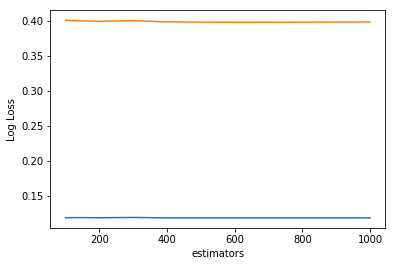

In [143]:
from sklearn.ensemble import RandomForestClassifier

estimators = [100,150,200,300,400,600,800,1000]#parameter tuning of n_estimators
test_scores = []
train_scores = []
for i in estimators:
    clf = RandomForestClassifier(n_estimators=i,n_jobs=-1)
    clf.fit(X_train,y_train)
    predict_y = clf.predict_proba(X_train)
    log_loss_train = log_loss(y_train, predict_y, eps=1e-15)
    train_scores.append(log_loss_train)
    predict_y = clf.predict_proba(X_test)
    log_loss_test = log_loss(y_test, predict_y, eps=1e-15)
    test_scores.append(log_loss_test)
    print('estimators = ',i,'\Train Log Loss ',log_loss_train,'\Test Log Loss ',log_loss_test,'\Loss difference between Test and Train',(log_loss_test-log_loss_train))
plt.plot(estimators,train_scores,label='Train Log Loss')
plt.plot(estimators,test_scores,label='Test Log Loss')
plt.xlabel('estimators')
plt.ylabel('Log Loss')



max_depth =  5 \Train Log Loss  0.48863178214979985 \Test Log Loss  0.4901136871928441 \Loss difference between Test and Train 0.0014819050430442404
max_depth =  10 \Train Log Loss  0.3862399450082819 \Test Log Loss  0.42688462404211397 \Loss difference between Test and Train 0.040644679033832065
max_depth =  12 \Train Log Loss  0.3391933487166792 \Test Log Loss  0.41681666365720615 \Loss difference between Test and Train 0.07762331494052693
max_depth =  15 \Train Log Loss  0.2638076237130832 \Test Log Loss  0.4045665709195243 \Loss difference between Test and Train 0.1407589472064411
max_depth =  20 \Train Log Loss  0.1704954957123335 \Test Log Loss  0.3981669882751069 \Loss difference between Test and Train 0.2276714925627734
max_depth =  25 \Train Log Loss  0.13278493052707965 \Test Log Loss  0.399148821705002 \Loss difference between Test and Train 0.26636389117792236
max_depth =  50 \Train Log Loss  0.1192817173812363 \Test Log Loss  0.39886050773743936 \Loss difference between Te

Text(0, 0.5, 'Log Loss')

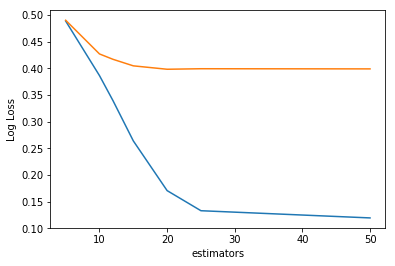

In [162]:
from sklearn.ensemble import RandomForestClassifier
max_depth = [5,10,12,15,20,25,50]#parameter tuning of max_depth
test_scores = []
train_scores = []
for i in max_depth:
    clf = RandomForestClassifier(n_estimators=200,max_depth=i,n_jobs=-1)
    clf.fit(X_train,y_train)
    predict_y = clf.predict_proba(X_train)
    log_loss_train = log_loss(y_train, predict_y, eps=1e-15)
    train_scores.append(log_loss_train)
    predict_y = clf.predict_proba(X_test)
    log_loss_test = log_loss(y_test, predict_y, eps=1e-15)
    test_scores.append(log_loss_test)
    print('max_depth = ',i,'\Train Log Loss ',log_loss_train,'\Test Log Loss ',log_loss_test,'\Loss difference between Test and Train',(log_loss_test-log_loss_train))
plt.plot(max_depth,train_scores,label='Train Log Loss')
plt.plot(max_depth,test_scores,label='Test Log Loss')
plt.xlabel('estimators') 
plt.ylabel('Log Loss')

<h2> 4.7 XGBoost </h2>

In [131]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.684835	valid-logloss:0.684836
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.614112	valid-logloss:0.614417
[20]	train-logloss:0.562635	valid-logloss:0.563284
[30]	train-logloss:0.524543	valid-logloss:0.525426
[40]	train-logloss:0.494937	valid-logloss:0.496053
[50]	train-logloss:0.471567	valid-logloss:0.472895
[60]	train-logloss:0.453167	valid-logloss:0.454783
[70]	train-logloss:0.438451	valid-logloss:0.4403
[80]	train-logloss:0.426399	valid-logloss:0.428499
[90]	train-logloss:0.416593	valid-logloss:0.418929
[100]	train-logloss:0.408375	valid-logloss:0.410954
[110]	train-logloss:0.401531	valid-logloss:0.404315
[120]	train-logloss:0.395824	valid-logloss:0.398822
[130]	train-logloss:0.39095	valid-logloss:0.39417
[140]	train-logloss:0.38671	valid-logloss:0.390106
[150]	train-logloss:0.383088	valid-logloss:0.386707
[160]	train-logloss:0.379793	vali

Total number of data points : 30000


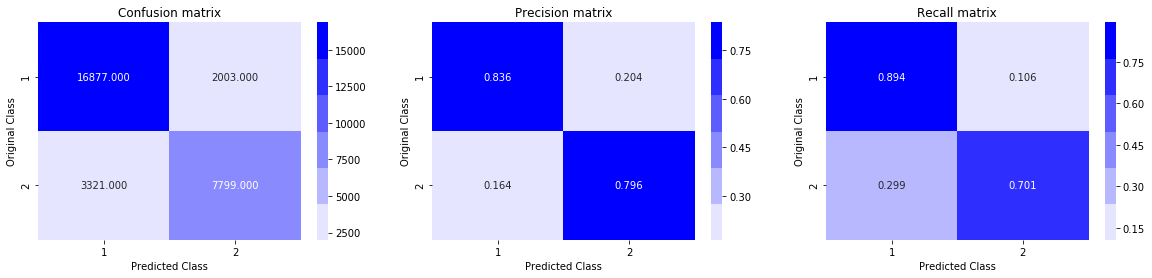

In [132]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

estimators =  100 \Train Log Loss  0.3520918919883469 \Test Log Loss  0.36033774787196693 \Loss difference between Test and Train 0.008245855883620035
estimators =  150 \Train Log Loss  0.3386067277158267 \Test Log Loss  0.3522854916805571 \Loss difference between Test and Train 0.01367876396473039
estimators =  200 \Train Log Loss  0.32894167827243065 \Test Log Loss  0.34759422810151447 \Loss difference between Test and Train 0.01865254982908382
estimators =  300 \Train Log Loss  0.3140667085818772 \Test Log Loss  0.3424556160513312 \Loss difference between Test and Train 0.028388907469453994
estimators =  400 \Train Log Loss  0.3020910926285514 \Test Log Loss  0.3397144092008269 \Loss difference between Test and Train 0.03762331657227552
estimators =  600 \Train Log Loss  0.281438358529511 \Test Log Loss  0.33665017040698564 \Loss difference between Test and Train 0.05521181187747465
estimators =  800 \Train Log Loss  0.2636871281130271 \Test Log Loss  0.3346983053215395 \Loss differ

Text(0, 0.5, 'Log Loss')

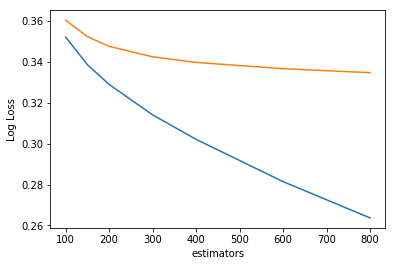

In [163]:
import xgboost as xgb
estimators = [100,150,200,300,400,600,800]#parameter tuning of estimators
test_scores = []
train_scores = []
for i in estimators:
    clf = xgb.XGBClassifier(max_depth=3,learning_rate=0.1,n_estimators=i,n_jobs=-1)
    clf.fit(X_train,y_train)
    predict_y = clf.predict_proba(X_train)
    log_loss_train = log_loss(y_train, predict_y, eps=1e-15)
    train_scores.append(log_loss_train)
    predict_y = clf.predict_proba(X_test)
    log_loss_test = log_loss(y_test, predict_y, eps=1e-15)
    test_scores.append(log_loss_test)
    print('estimators = ',i,'\Train Log Loss ',log_loss_train,'\Test Log Loss ',log_loss_test,'\Loss difference between Test and Train',(log_loss_test-log_loss_train))
plt.plot(estimators,train_scores,label='Train Log Loss')
plt.plot(estimators,test_scores,label='Test Log Loss')
plt.xlabel('estimators')
plt.ylabel('Log Loss')

etas =  0.05 \Train Log Loss  0.33404405607454496 \Test Log Loss  0.3500966360680497 \Loss difference between Test and Train 0.016052579993504734
etas =  0.1 \Train Log Loss  0.3080776209900883 \Test Log Loss  0.34115323456119184 \Loss difference between Test and Train 0.03307561357110356
etas =  0.15 \Train Log Loss  0.2886490469938293 \Test Log Loss  0.33777336127642726 \Loss difference between Test and Train 0.04912431428259795
etas =  0.2 \Train Log Loss  0.2737953168939112 \Test Log Loss  0.338089583400328 \Loss difference between Test and Train 0.06429426650641684
etas =  0.25 \Train Log Loss  0.25805278436166057 \Test Log Loss  0.33919091982007377 \Loss difference between Test and Train 0.0811381354584132
etas =  0.3 \Train Log Loss  0.24502072956237503 \Test Log Loss  0.34125356696040937 \Loss difference between Test and Train 0.09623283739803434


Text(0, 0.5, 'Log Loss')

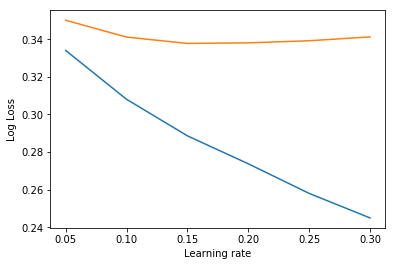

In [164]:
test_scores = []
train_scores = []
etas = [0.05,0.1,0.15,0.2,0.25,0.3]#parameter tuning of etas
for i in etas:
    clf = xgb.XGBClassifier(max_depth=3,learning_rate=i,n_estimators=350,n_jobs=-1)
    clf.fit(X_train,y_train)
    predict_y = clf.predict_proba(X_train)
    log_loss_train = log_loss(y_train, predict_y, eps=1e-15)
    train_scores.append(log_loss_train)
    predict_y = clf.predict_proba(X_test)
    log_loss_test = log_loss(y_test, predict_y, eps=1e-15)
    test_scores.append(log_loss_test)
    print('etas = ',i,'\Train Log Loss ',log_loss_train,'\Test Log Loss ',log_loss_test,'\Loss difference between Test and Train',(log_loss_test-log_loss_train))
plt.plot(etas,train_scores,label='Train Log Loss')
plt.plot(etas,test_scores,label='Test Log Loss')
plt.xlabel('Learning rate')
plt.ylabel('Log Loss')

reg_alpha =  0.5 \Train Log Loss  0.28897244242520403 \Test Log Loss  0.3384610079436542 \Loss difference between Test and Train 0.049488565518450156
reg_alpha =  1 \Train Log Loss  0.2887683413209859 \Test Log Loss  0.3376581923455339 \Loss difference between Test and Train 0.048889851024548014
reg_alpha =  5 \Train Log Loss  0.2902958983073865 \Test Log Loss  0.33665382856391185 \Loss difference between Test and Train 0.04635793025652535
reg_alpha =  10 \Train Log Loss  0.29275427954785277 \Test Log Loss  0.33830024600335384 \Loss difference between Test and Train 0.045545966455501075
reg_alpha =  50 \Train Log Loss  0.3099339141283263 \Test Log Loss  0.3416505975324515 \Loss difference between Test and Train 0.0317166834041252
reg_alpha =  100 \Train Log Loss  0.3257928809431814 \Test Log Loss  0.3478846232917587 \Loss difference between Test and Train 0.022091742348577303
reg_alpha =  150 \Train Log Loss  0.34771374308032016 \Test Log Loss  0.35905437562350806 \Loss difference betw

Text(0, 0.5, 'Log Loss')

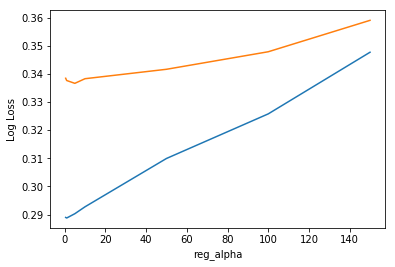

In [168]:

test_scores = []
train_scores = []
alpha = [0.5,1,5,10,50,100,150]#parameter tuning of alpha
for i in alpha:
    clf = xgb.XGBClassifier(max_depth=3,learning_rate=0.15,n_estimators=350,reg_alpha=i,n_jobs=-1)
    clf.fit(X_train,y_train)
    predict_y = clf.predict_proba(X_train)
    log_loss_train = log_loss(y_train, predict_y, eps=1e-15)
    train_scores.append(log_loss_train)
    predict_y = clf.predict_proba(X_test)
    log_loss_test = log_loss(y_test, predict_y, eps=1e-15)
    test_scores.append(log_loss_test)
    print('reg_alpha = ',i,'\Train Log Loss ',log_loss_train,'\Test Log Loss ',log_loss_test,'\Loss difference between Test and Train',(log_loss_test-log_loss_train))
plt.plot(alpha,train_scores,label='Train Log Loss')
plt.plot(alpha,test_scores,label='Test Log Loss')
plt.xlabel('reg_alpha')
plt.ylabel('Log Loss')

The test log loss is: 0.33777336127642726


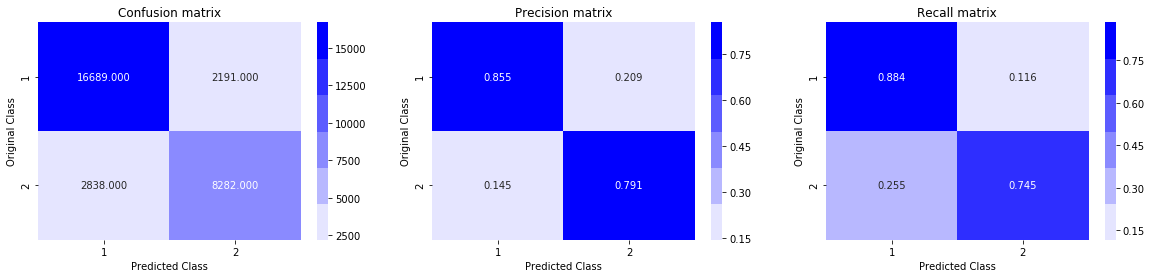

In [169]:
import xgboost as xgb
clf = xgb.XGBClassifier(max_depth=3,learning_rate=0.15,n_estimators=350,n_jobs=-1)
clf.fit(X_train,y_train)
predict_y = clf.predict_proba(X_test)
print("The test log loss is:",log_loss(y_test, predict_y, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h1> 5. Assignments </h1>


1. Try out models (Logistic regression, Linear-SVM) with simple TF-IDF vectors instead of TD_IDF weighted word2Vec.
2. Hyperparameter tune XgBoost using RandomSearch to reduce the log-loss.


## Perfom Modeling on complete dataset with TF-IDF Features

In [29]:
# Load Basic Features
import pandas as pd
df_basic_feature = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')

In [30]:
print("Columns : ",df_basic_feature.columns)
print("\nNumber of columns : ",len(df_basic_feature.columns))

df_basic_feature.head()

Columns :  Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2'],
      dtype='object')

Number of columns :  17


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [31]:
# Load Advance Features
df_advance_features = pd.read_csv("nlp_features_train.csv",encoding='latin-1')

In [32]:
print("Columns : ",df_advance_features.columns)
print("\nNumber of columns : ",len(df_advance_features.columns))

df_advance_features.head()

Columns :  Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

Number of columns :  21


,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,...,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,0.399992,0.199998,0.999950,0.666644,...,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [33]:
# Columns dropped from basic feature dataframe 
df_basic_feature = df_basic_feature.drop(['qid1','qid2'],axis=1)

# Columns dropped from advance feature dataframe 
df_advance_features = df_advance_features.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

# Lets add both the truncated dataframe into one dataframe
df_basic_advance_features  = df_basic_feature.merge(df_advance_features, on='id',how='left')

In [34]:
#checking nan value
nan_rows = df_basic_advance_features[df_basic_advance_features.isnull().any(1)]
print (nan_rows)

            id                         question1  \
105780  105780    How can I develop android app?   
201841  201841  How can I create an Android app?   
363362  363362                               NaN   

                                                question2  is_duplicate  \
105780                                                NaN             0   
201841                                                NaN             0   
363362  My Chinese name is Haichao Yu. What English na...             0   

        freq_qid1  freq_qid2  q1len  q2len  q1_n_words  q2_n_words  ...  \
105780          2          2     30      0           6           1  ...   
201841          1          2     32      0           7           1  ...   
363362          1          1      3    123           1          21  ...   

        ctc_max  last_word_eq  first_word_eq  abs_len_diff  mean_len  \
105780      0.0           0.0            0.0           0.0       0.0   
201841      0.0           0.0            0.0 

In [35]:
df_basic_advance_features = df_basic_advance_features[df_basic_advance_features['question1'].notnull()]
df_basic_advance_features = df_basic_advance_features[df_basic_advance_features['question2'].notnull()]

In [36]:
nan_rows = df_basic_advance_features[df_basic_advance_features.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, question1, question2, is_duplicate, freq_qid1, freq_qid2, q1len, q2len, q1_n_words, q2_n_words, word_Common, word_Total, word_share, freq_q1+q2, freq_q1-q2, cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, token_set_ratio, token_sort_ratio, fuzz_ratio, fuzz_partial_ratio, longest_substr_ratio]
Index: []

[0 rows x 30 columns]


In [37]:
print("Columns : ",df_basic_advance_features.columns)
print("\nNumber of columns : ",len(df_basic_advance_features.columns))

df_basic_advance_features.head()

Columns :  Index(['id', 'question1', 'question2', 'is_duplicate', 'freq_qid1',
       'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

Number of columns :  30


,id,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,...,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,...,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,...,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [38]:

target = df_basic_advance_features['is_duplicate']

In [39]:
#Also drop the unnecessary id and is_duplicate column from feature dataset
df_basic_advance_features.drop(['id','is_duplicate'], axis=1, inplace=True)

In [40]:
print("Columns : ",df_basic_advance_features.columns)
print("\nNumber of columns : ",len(df_basic_advance_features.columns))

df_basic_advance_features.head()

Columns :  Index(['question1', 'question2', 'freq_qid1', 'freq_qid2', 'q1len', 'q2len',
       'q1_n_words', 'q2_n_words', 'word_Common', 'word_Total', 'word_share',
       'freq_q1+q2', 'freq_q1-q2', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max',
       'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff',
       'mean_len', 'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

Number of columns :  28


,question1,question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,1,1,66,57,14,12,10.0,23.0,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,4,1,51,88,8,13,4.0,20.0,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,1,1,73,59,14,10,4.0,24.0,...,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,1,1,50,65,11,9,0.0,19.0,...,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,3,1,76,39,13,7,2.0,20.0,...,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


### train test split

In [41]:
x_train,x_test, y_train, y_test = train_test_split(df_basic_advance_features, target, stratify=target, test_size=0.3)
print("Number of data points in train data :",x_train.shape)
print("Number of data points in test data :",x_test.shape)

Number of data points in train data : (283000, 28)
Number of data points in test data : (121287, 28)


#### Perform TF-IDF Tokenization on columns- 'question1', 'question2'

###### Train

In [42]:
# Instanciate Tfidf Vectorizer 
tfidfVectorizer_question1 = TfidfVectorizer()

question1_dtm_train = tfidfVectorizer_question1.fit_transform(x_train['question1'].values.astype('U'))
question1_dtm_test = tfidfVectorizer_question1.transform(x_test['question1'].values.astype('U'))
print("Found {0} features from question1 column".format(len(tfidfVectorizer_question1.get_feature_names())))

Found 57848 features from question1 column


In [43]:
# Instanciate Tfidf Vectorizer 
tfidfVectorizer_question2 = TfidfVectorizer()

question2_dtm_train = tfidfVectorizer_question2.fit_transform(x_train['question2'].values.astype('U'))
question2_dtm_test = tfidfVectorizer_question2.transform(x_test['question2'].values.astype('U'))
print("Found {0} features from question2_train column".format(len(tfidfVectorizer_question2.get_feature_names())))

Found 53566 features from question2_train column


In [44]:
# Combine all the features in question1 and question2
question1_question2_train = hstack((question1_dtm_train,question2_dtm_train))
question1_question2_test = hstack((question1_dtm_test,question2_dtm_test))
type(question1_question2_train)

scipy.sparse.coo.coo_matrix

In [45]:
# Drop unnecessary question1 and question2 columns
x_train.drop(['question1','question2'], axis=1, inplace=True)
# Combine all basic, advance and tfidf features
x_train_tfidf_features = hstack((x_train, question1_question2_train),format="csr",dtype='float64')
x_train_tfidf_features.shape

(283000, 111440)

In [46]:
# Drop unnecessary question1 and question2 columns
x_test.drop(['question1','question2'], axis=1, inplace=True)
# Combine all basic, advance and tfidf features
x_test_tfidf_features = hstack((x_test, question1_question2_test),format="csr",dtype='float64')
x_test_tfidf_features.shape

(121287, 111440)

### Split data into 70:30

In [28]:
# x_train,x_test, y_train, y_test = train_test_split(df_basic_advance_tfidf_features, target, stratify=target, test_size=0.3)
# print("Number of data points in train data :",x_train.shape)
# print("Number of data points in test data :",x_test.shape)

# Apply ML Models

#### Random Model

Log loss on Test Data using Random Model 0.8849045534422261


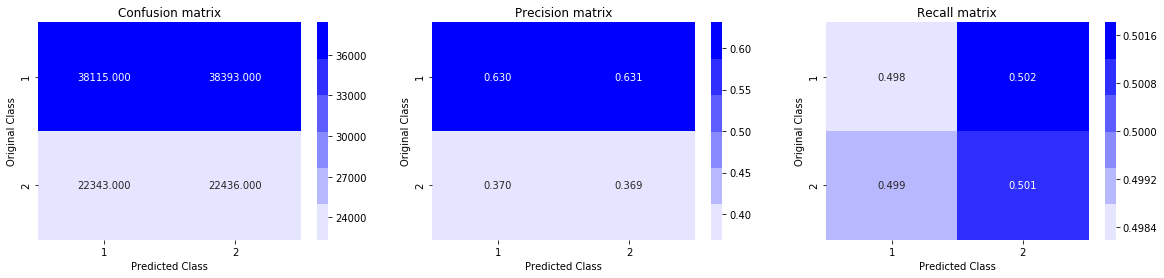

In [47]:

test_len = len(y_test)
predicted_y = np.zeros((len(y_test),2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

#### Logistic Regression with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.41782178964874295


C:\Users\Raftaar Singh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Raftaar Singh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Raftaar Singh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Raftaar Singh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


For values of alpha =  0.0001 The log loss is: 0.4606858822824733
For values of alpha =  0.001 The log loss is: 0.46367537844625883
For values of alpha =  0.01 The log loss is: 0.4336750326736649
For values of alpha =  0.1 The log loss is: 0.4496524359766333
For values of alpha =  1 The log loss is: 0.4863860139423144
For values of alpha =  10 The log loss is: 0.5398338747154164


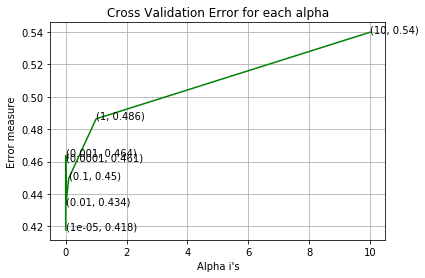

For values of best alpha =  1e-05 The train log loss is: 0.41998037298377994
For values of best alpha =  1e-05 The test log loss is: 0.41782178964874295
Total number of data points : 121287


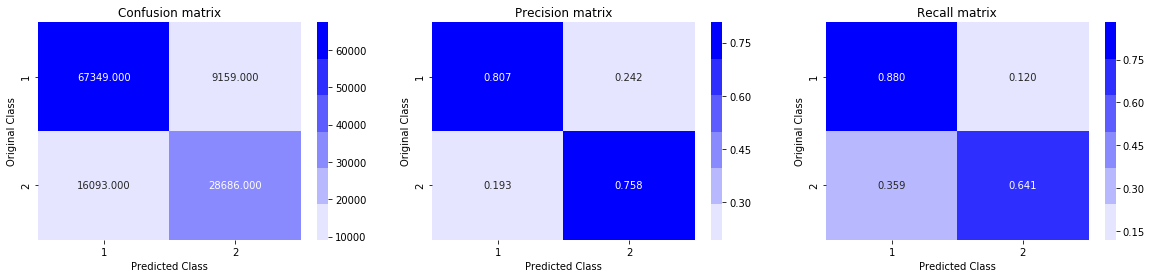

In [48]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(x_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train, y_train)
    predict_y = sig_clf.predict_proba(x_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(x_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train, y_train)

predict_y = sig_clf.predict_proba(x_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

#### Linear SVM with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.43796355338810594
For values of alpha =  0.0001 The log loss is: 0.451987824474239
For values of alpha =  0.001 The log loss is: 0.4499942353531707
For values of alpha =  0.01 The log loss is: 0.4879424270158445
For values of alpha =  0.1 The log loss is: 0.48480526664962936
For values of alpha =  1 The log loss is: 0.5706653986567619
For values of alpha =  10 The log loss is: 0.603250737287541


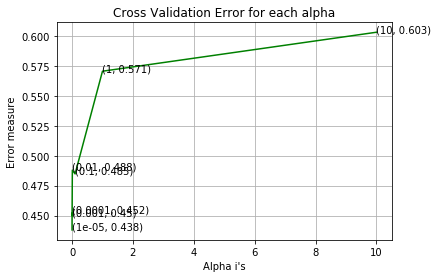

For values of best alpha =  1e-05 The train log loss is: 0.4403196097859522
For values of best alpha =  1e-05 The test log loss is: 0.43796355338810594
Total number of data points : 121287


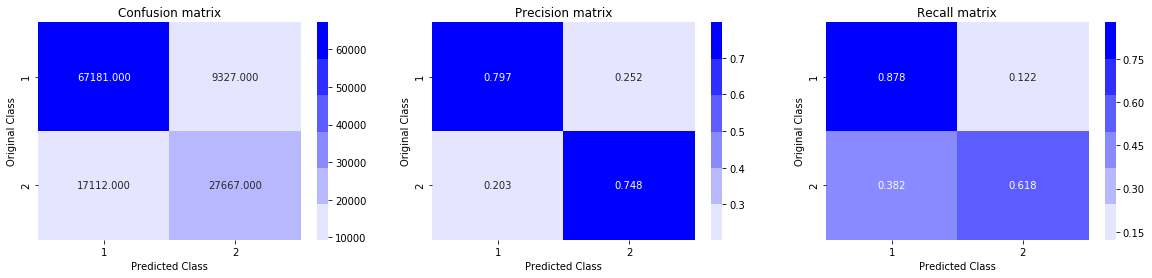

In [41]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(x_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train, y_train)
    predict_y = sig_clf.predict_proba(x_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(x_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train, y_train)

predict_y = sig_clf.predict_proba(x_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

#### XGBoost Model

In [26]:
import pickle

In [27]:
#https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.training
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ParameterGrid
import random,math
from random import randint
from random import uniform

param_dist = {"max_depth": [randint(2,5)],
              "learning_rate":[uniform(0,0.25)],
              "n_estimators":[randint(100,600)],
              "min_child_weight": [randint(2, 8)],
              "gamma": [uniform(0,4)],
              "subsample":[uniform(0.3,0.7)],
              "colsample_bytree": [uniform(0.3,0.7)],
              "reg_alpha":[uniform(100,300)],
              "reg_lambda":[uniform(100,300)]}

xgb_classifier= xgb.XGBClassifier(n_jobs=-1,random_state=25)
model_rs_xgb = RandomizedSearchCV(xgb_classifier, param_distributions=param_dist,n_iter=30,scoring='neg_log_loss',cv=10,n_jobs=-1)
model_rs_xgb.fit(x_train,y_train)
pickle.dump(model_rs_xgb,open('model_rs_xgb.p','wb'))

C:\Users\Raftaar Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


In [28]:
model_rs_xgb.best_params_

{'subsample': 0.3603078423439581,
 'reg_lambda': 175.72730927632995,
 'reg_alpha': 186.73811227055532,
 'n_estimators': 289,
 'min_child_weight': 2,
 'max_depth': 3,
 'learning_rate': 0.1141562740879572,
 'gamma': 3.506406220455274,
 'colsample_bytree': 0.46270301657898855}

In [34]:
model_rs_xgb.cv_results_

{'mean_fit_time': array([748.59955781]),
 'std_fit_time': array([98.38368188]),
 'mean_score_time': array([3.48462224]),
 'std_score_time': array([1.51216964]),
 'param_subsample': masked_array(data=[0.3603078423439581],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_reg_lambda': masked_array(data=[175.72730927632995],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_reg_alpha': masked_array(data=[186.73811227055532],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[289],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_min_child_weight': masked_array(data=[2],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[3],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_array(

Train log loss =  0.3450527233776131  Test log loss =  0.3448455175883942


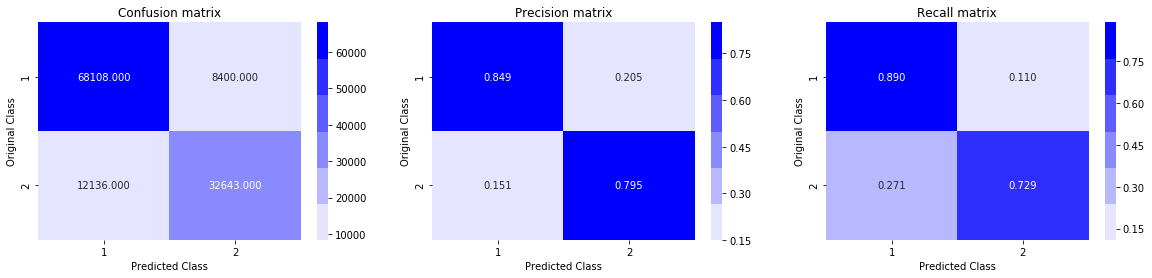

In [33]:
import xgboost as xgb
clf = xgb.XGBClassifier(max_depth=3,learning_rate=0.1141562740879572,n_estimators=289,min_child_weight=2,
                        reg_alpha=186.73811227055532,reg_lambda=175.72730927632995,
                        gamma=3.506406220455274,colsample_bytree=0.46270301657898855,n_jobs=-1)
clf.fit(x_train,y_train)
y_pred_test=clf.predict_proba(x_test)
y_pred_train=clf.predict_proba(x_train)
log_loss_train_xgb = log_loss(y_train, y_pred_train, eps=1e-15)
log_loss_test_xgb=log_loss(y_test,y_pred_test,eps=1e-15)
print('Train log loss = ',log_loss_train_xgb,' Test log loss = ',log_loss_test_xgb)
predicted_y =np.argmax(y_pred_test,axis=1)
plot_confusion_matrix(y_test, predicted_y)

In [241]:
#!pip install PrettyTable

  Stored in directory: C:\Users\IDM LAB-01\AppData\Local\pip\Cache\wheels\80\34\1c\3967380d9676d162cb59513bd9dc862d0584e045a162095606
Successfully built PrettyTable


In [35]:
from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ["Model","vectorizer","logloss_train","logloss_test","logloss_train(with standardized)","logloss_test(with standardized)"]
x.add_row(['Random model','TFIDF w2vec', '---'  , '0.8851460427625617','---','---'])
x.add_row(['Logistic regression','TFIDF w2vec','0.50036000082','0.505431586320','0.403156873165','0.413104155793449'])
x.add_row(['Linear SVM','TFIDF w2vec','0.478578596724142','0.4876647905346559','0.4180234067450405','0.4268263608040993'])
x.add_row(['XGBOOST','TFIDF w2vec', '0.341883'  , '0.354821','---','---'])
x.add_row(['Logistic regression','TFIDF ','0.38391764443576326'   , '0.38735168107931295' , '---','---'])
x.add_row(['Linear SVM','TFIDF',  '0.422794770596703'  , '0.42897445455959393','---','---'])
x.add_row(['XGBOOST_tuned','TFIDF ','0.3450527233776131','0.3448455175883942','---','---'])

print(x)

+---------------------+-------------+---------------------+---------------------+----------------------------------+---------------------------------+
|        Model        |  vectorizer |    logloss_train    |     logloss_test    | logloss_train(with standardized) | logloss_test(with standardized) |
+---------------------+-------------+---------------------+---------------------+----------------------------------+---------------------------------+
|     Random model    | TFIDF w2vec |         ---         |  0.8851460427625617 |               ---                |               ---               |
| Logistic regression | TFIDF w2vec |    0.50036000082    |    0.505431586320   |          0.403156873165          |        0.413104155793449        |
|      Linear SVM     | TFIDF w2vec |  0.478578596724142  |  0.4876647905346559 |        0.4180234067450405        |        0.4268263608040993       |
|       XGBOOST       | TFIDF w2vec |       0.341883      |       0.354821      |             

In [32]:
from prettytable import PrettyTable

data = x.get_string()

with open('Quora.txt', 'w') as f:
    f.write(data)

Observation:

    1)Best Model: Train test log loss found using XGBoost RandomserachCV tunned model Iis lowest and difference between train and test is in significant so the model is not overfitting.
    
    2)Worst Model: Random model is worst model with maximum log loss value of 0.88.
    
    3)Overall log loss occure in all Model using TFIDF vectorized dataset is less than occure with TFIDF weifgted W2V . this may be because TFIDF have high sparsity than TFIDF weifgted W2V.